# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""
embeddings = None
temp_prec = ['../Tabular_data/precipitation_all.csv', '../Tabular_data/temperature_all 2.csv']
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/variational_autoencoder_224_1024.csv')['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, temp_prec=temp_prec) for Municipality in Municipalities]
type(dengue_df)

list

### Train Test split

In [4]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)
The train shape is: (130, 3)
The test shape is: (33, 3)


### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

temperature  precipitation    Labels
41001 201546     0.109192      -0.384028 -0.861740
      201547    -0.038879      -0.701050 -0.854589
      201548     0.320644      -0.582182 -0.856973
      201549     0.490532      -0.884511 -0.856973
      201550     0.369630      -0.361735 -0.823600

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

temperature  precipitation    Labels
41001 201820    -0.094121      -0.653238 -0.949940
      201821     0.023351      -0.600049 -0.961859
      201822    -0.187106      -0.633564 -0.940405
      201823    -0.214029      -0.884182 -0.961859
      201824    -0.071286      -0.846962 -0.954708

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 7)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [10]:
train.shape

(1280, 7)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 6)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 6)
The shape of the labels is (310, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 6)
The test shape is (310, 6)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 2)
The test shape is (310, 3, 2)


# 2. Model

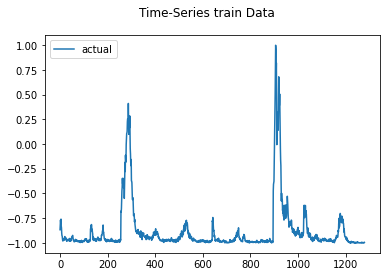

2023-03-09 13:25:05.135725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-09 13:25:05.135770: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-09 13:25:05.135793: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-09 13:25:05.135986: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 13:25:06.507357: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 25.145
Test RMSE: 38.547
Test sMAPE: 97.766
Test R Squared: -0.498
{'mae': 25.14514197572585, 'rmse': 38.546745449897905, 'smape': 97.76570346882528, 'r2': -0.49765012231252603}


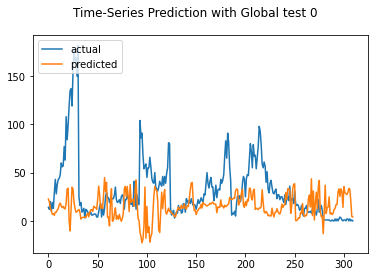

Test MAE: 40.038
Test RMSE: 47.288
Test sMAPE: 99.835
Test R Squared: -1.254
{'mae': 40.0382759967158, 'rmse': 47.28762938562368, 'smape': 99.83522236538192, 'r2': -1.2538760031156677}


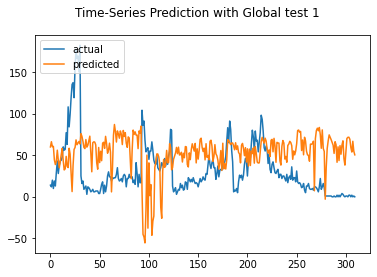

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 36.483
Test RMSE: 44.141
Test sMAPE: 92.517
Test R Squared: -0.964
{'mae': 36.48302837494881, 'rmse': 44.14059423155747, 'smape': 92.51726897843083, 'r2': -0.9638634406947943}


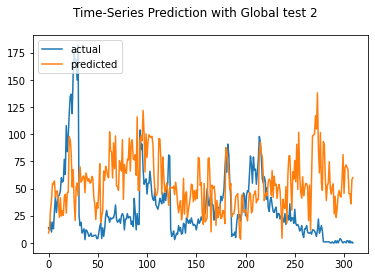

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 29.119
Test RMSE: 36.172
Test sMAPE: 84.391
Test R Squared: -0.319
{'mae': 29.119106043538746, 'rmse': 36.17240420591786, 'smape': 84.39077012106051, 'r2': -0.31883263343786994}


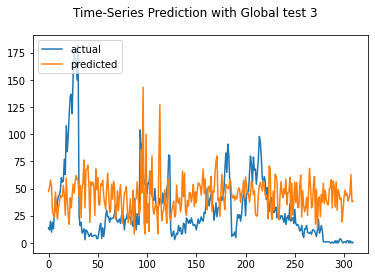

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 32.418
Test RMSE: 39.647
Test sMAPE: 88.088
Test R Squared: -0.584
{'mae': 32.418435090587984, 'rmse': 39.647496400428494, 'smape': 88.0877622425274, 'r2': -0.5844059738424974}


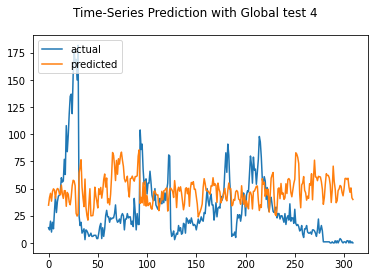

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 39.111
Test RMSE: 46.177
Test sMAPE: 102.657
Test R Squared: -1.149
{'mae': 39.111473585617155, 'rmse': 46.17651170697178, 'smape': 102.65701747945332, 'r2': -1.1492017161091193}


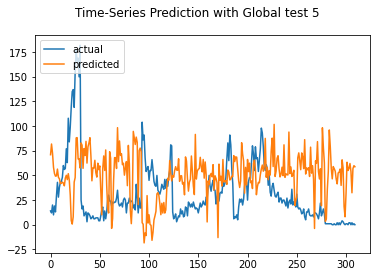

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 26.529
Test RMSE: 37.805
Test sMAPE: 91.448
Test R Squared: -0.441
{'mae': 26.529134431096814, 'rmse': 37.80474983844443, 'smape': 91.44804371427715, 'r2': -0.4405477938354929}


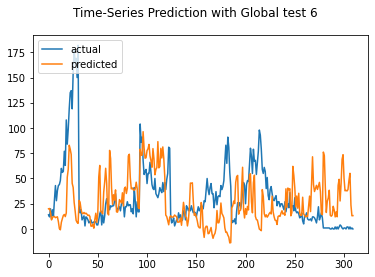

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 31.176
Test RMSE: 42.389
Test sMAPE: 86.980
Test R Squared: -0.811
{'mae': 31.175545866162548, 'rmse': 42.38924943563995, 'smape': 86.97974821866227, 'r2': -0.8111165038418973}


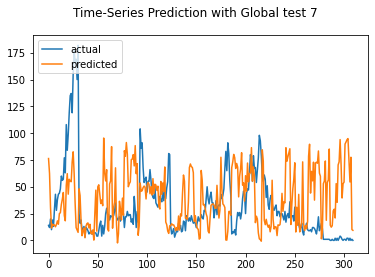

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 29.500
Test RMSE: 38.476
Test sMAPE: 96.847
Test R Squared: -0.492
{'mae': 29.499659359070563, 'rmse': 38.47605209259673, 'smape': 96.84712301796539, 'r2': -0.4921618856543746}


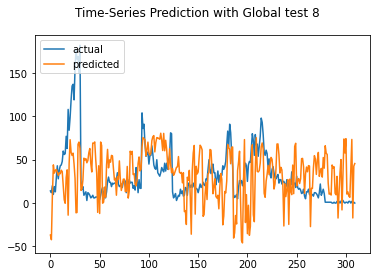

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 24.778
Test RMSE: 33.528
Test sMAPE: 78.505
Test R Squared: -0.133
{'mae': 24.777677443719682, 'rmse': 33.52791827834767, 'smape': 78.50518990091334, 'r2': -0.13304748993421023}


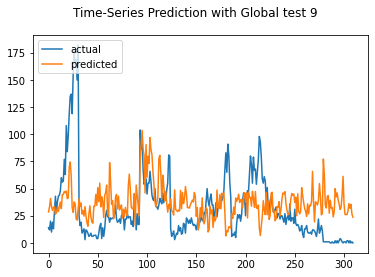

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 25.266
Test RMSE: 33.862
Test sMAPE: 77.747
Test R Squared: -0.156
{'mae': 25.266295971024427, 'rmse': 33.861719447878535, 'smape': 77.74688284525408, 'r2': -0.15572085131745528}


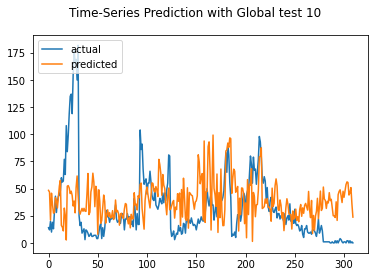

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 36.689
Test RMSE: 43.671
Test sMAPE: 93.086
Test R Squared: -0.922
{'mae': 36.6889812807883, 'rmse': 43.67126668664587, 'smape': 93.0863883601994, 'r2': -0.922323663850739}


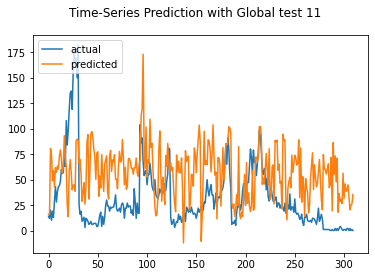

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 35.199
Test RMSE: 40.899
Test sMAPE: 91.320
Test R Squared: -0.686
{'mae': 35.198547917027625, 'rmse': 40.89928274097602, 'smape': 91.31992571623186, 'r2': -0.6860339604090517}


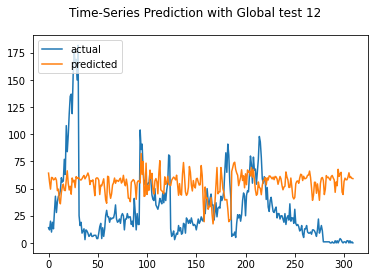

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 28.837
Test RMSE: 40.361
Test sMAPE: 134.066
Test R Squared: -0.642
{'mae': 28.83675239201515, 'rmse': 40.36147298717605, 'smape': 134.06644157165184, 'r2': -0.6419841071666503}


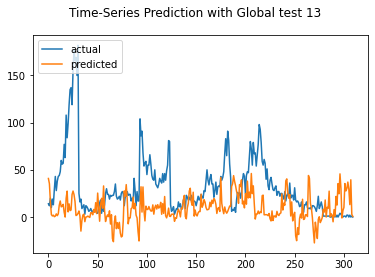

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 24.545
Test RMSE: 36.638
Test sMAPE: 93.649
Test R Squared: -0.353
{'mae': 24.544672214600347, 'rmse': 36.6380371443794, 'smape': 93.64903790780318, 'r2': -0.35300478252286904}


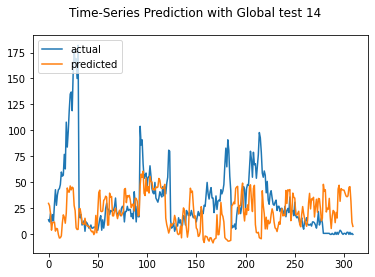

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 25.297
Test RMSE: 40.021
Test sMAPE: 100.905
Test R Squared: -0.614
{'mae': 25.297137461939162, 'rmse': 40.02115050308561, 'smape': 100.90470651086883, 'r2': -0.6144108701836339}


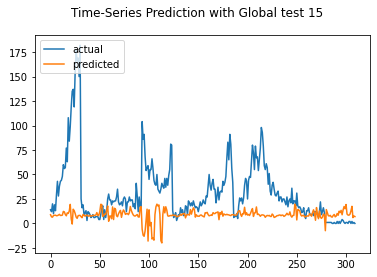

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 25.010
Test RMSE: 34.465
Test sMAPE: 81.772
Test R Squared: -0.197
{'mae': 25.0100989618609, 'rmse': 34.46460600742715, 'smape': 81.77231237758502, 'r2': -0.19724097148706332}


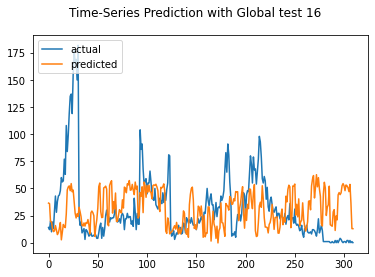

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 31.235
Test RMSE: 38.201
Test sMAPE: 84.259
Test R Squared: -0.471
{'mae': 31.234705020535376, 'rmse': 38.200618236216805, 'smape': 84.25936764974247, 'r2': -0.47087483455393797}


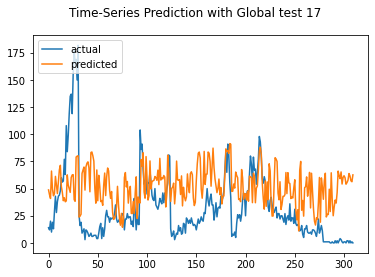

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 36.024
Test RMSE: 44.333
Test sMAPE: 88.857
Test R Squared: -0.981
{'mae': 36.024312723836594, 'rmse': 44.33293549272732, 'smape': 88.85684196766208, 'r2': -0.981015676869845}


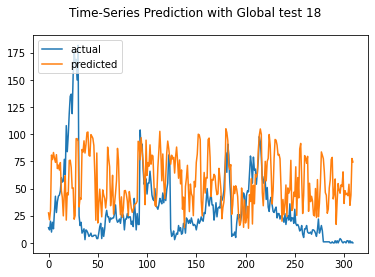

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 35.251
Test RMSE: 44.305
Test sMAPE: 95.299
Test R Squared: -0.978
{'mae': 35.25104769583671, 'rmse': 44.30473063990861, 'smape': 95.29868740599493, 'r2': -0.9784958129706742}


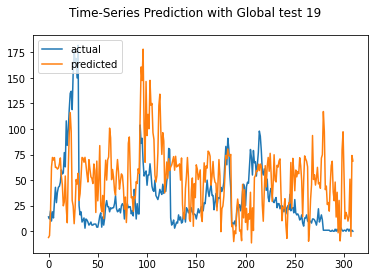

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 36.134
Test RMSE: 42.992
Test sMAPE: 95.013
Test R Squared: -0.863
{'mae': 36.13394519052198, 'rmse': 42.99235116144726, 'smape': 95.01316716528457, 'r2': -0.8630191855691276}


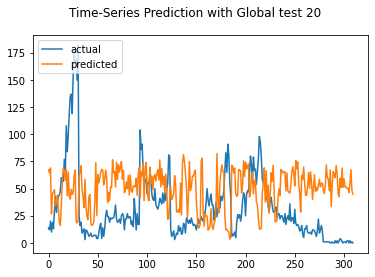

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 39.355
Test RMSE: 45.407
Test sMAPE: 94.346
Test R Squared: -1.078
{'mae': 39.35510874717466, 'rmse': 45.40662449133051, 'smape': 94.34616324375428, 'r2': -1.0781331498502382}


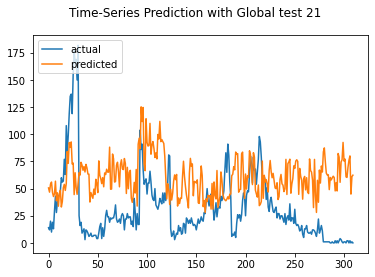

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 29.674
Test RMSE: 37.328
Test sMAPE: 95.444
Test R Squared: -0.404
{'mae': 29.673577394889247, 'rmse': 37.32752877989604, 'smape': 95.44422128943171, 'r2': -0.40440838080283115}


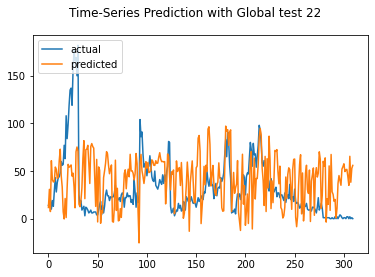

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 30.292
Test RMSE: 40.319
Test sMAPE: 99.473
Test R Squared: -0.638
{'mae': 30.292219731500072, 'rmse': 40.31862089889311, 'smape': 99.47326990892252, 'r2': -0.6384993435771729}


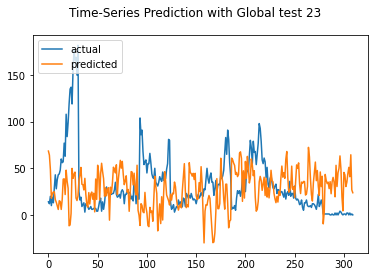

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 26.760
Test RMSE: 39.346
Test sMAPE: 115.166
Test R Squared: -0.560
{'mae': 26.760223536049168, 'rmse': 39.346352204497194, 'smape': 115.16617990082882, 'r2': -0.5604285397970212}


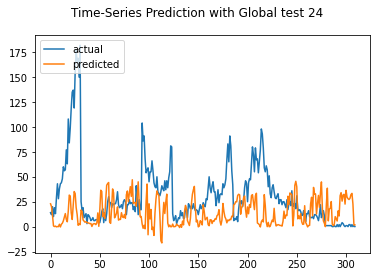

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 37.037
Test RMSE: 43.586
Test sMAPE: 92.209
Test R Squared: -0.915
{'mae': 37.03686738206494, 'rmse': 43.58595812457042, 'smape': 92.20949629064101, 'r2': -0.9148207674033508}


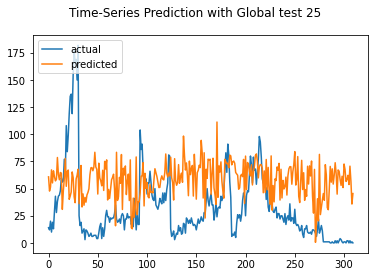

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 25.194
Test RMSE: 39.319
Test sMAPE: 99.410
Test R Squared: -0.558
{'mae': 25.194094377948392, 'rmse': 39.31900652812121, 'smape': 99.41026711537897, 'r2': -0.5582603008968638}


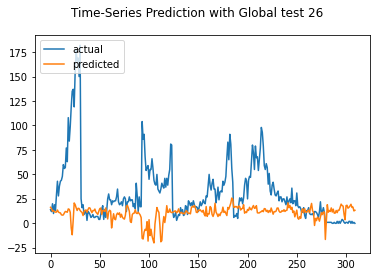

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 19.998
Test RMSE: 31.728
Test sMAPE: 70.687
Test R Squared: -0.015
{'mae': 19.997747419726466, 'rmse': 31.72823126555424, 'smape': 70.68659916059374, 'r2': -0.014674297140648829}


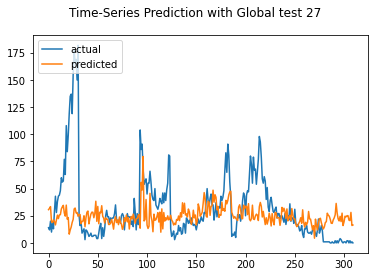

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 26.439
Test RMSE: 35.912
Test sMAPE: 78.037
Test R Squared: -0.300
{'mae': 26.439460280633742, 'rmse': 35.911580473418255, 'smape': 78.03671037600171, 'r2': -0.29988212677786774}


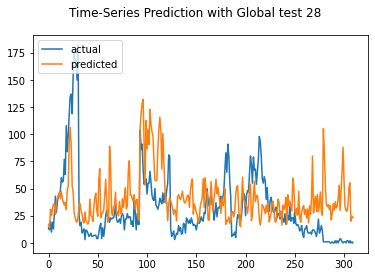

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 29.523
Test RMSE: 36.452
Test sMAPE: 85.564
Test R Squared: -0.339
{'mae': 29.52294238921135, 'rmse': 36.45218027017333, 'smape': 85.56357768413169, 'r2': -0.33931259567524075}


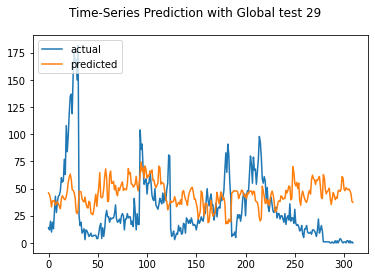

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 39.939
Test RMSE: 47.124
Test sMAPE: 96.255
Test R Squared: -1.238
{'mae': 39.938796434094826, 'rmse': 47.12413022833761, 'smape': 96.25499048720478, 'r2': -1.238317187110312}


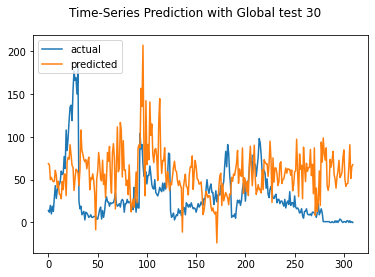

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 25.128
Test RMSE: 38.323
Test sMAPE: 118.887
Test R Squared: -0.480
{'mae': 25.12818984273941, 'rmse': 38.32310192716224, 'smape': 118.88659485820685, 'r2': -0.4803221686570722}


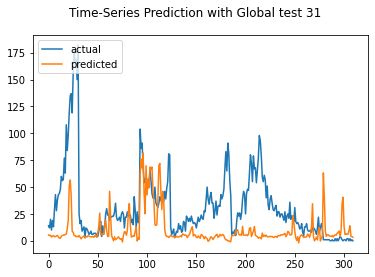

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 24.277
Test RMSE: 33.498
Test sMAPE: 84.761
Test R Squared: -0.131
{'mae': 24.277327781627257, 'rmse': 33.49782007381374, 'smape': 84.76134059463566, 'r2': -0.13101411656917095}


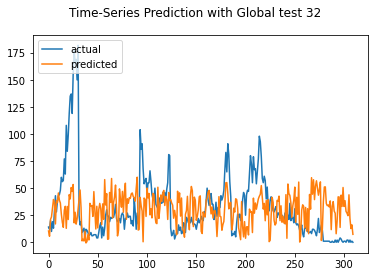

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 27.520
Test RMSE: 37.377
Test sMAPE: 104.729
Test R Squared: -0.408
{'mae': 27.52018826142434, 'rmse': 37.37676997525896, 'smape': 104.72919034857478, 'r2': -0.40811611946089443}


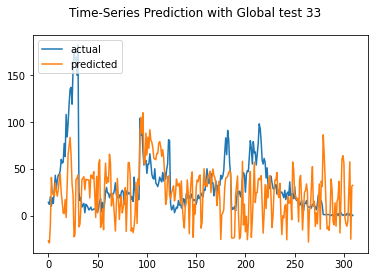

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 27.981
Test RMSE: 38.533
Test sMAPE: 83.041
Test R Squared: -0.497
{'mae': 27.980690849019634, 'rmse': 38.532635753271805, 'smape': 83.04059409547774, 'r2': -0.49655391970699325}


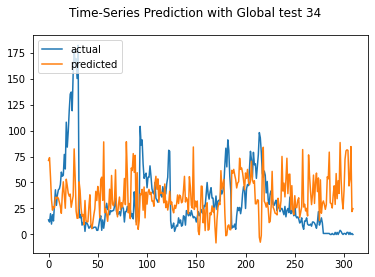

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 27.574
Test RMSE: 35.285
Test sMAPE: 86.404
Test R Squared: -0.255
{'mae': 27.57376150469626, 'rmse': 35.28514064236836, 'smape': 86.40367839217777, 'r2': -0.25492751086973553}


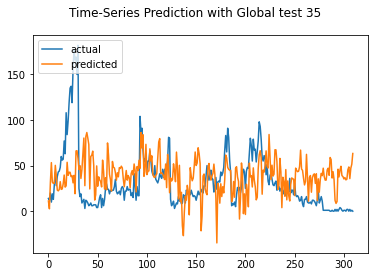

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 30.977
Test RMSE: 39.697
Test sMAPE: 87.580
Test R Squared: -0.588
{'mae': 30.97662971625405, 'rmse': 39.69663279272565, 'smape': 87.57952516391954, 'r2': -0.5883356159524018}


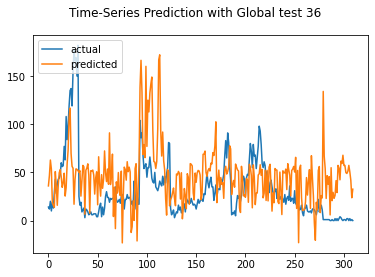

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 27.280
Test RMSE: 35.234
Test sMAPE: 86.011
Test R Squared: -0.251
{'mae': 27.280232403739806, 'rmse': 35.23392580017901, 'smape': 86.01112654479249, 'r2': -0.2512872095958876}


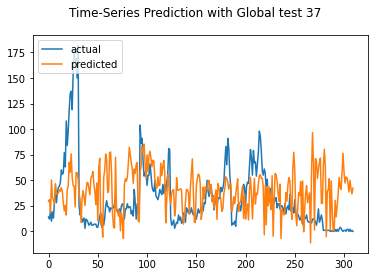

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 30.110
Test RMSE: 40.406
Test sMAPE: 112.271
Test R Squared: -0.646
{'mae': 30.109968893950985, 'rmse': 40.40612895021426, 'smape': 112.27090662634268, 'r2': -0.6456195019748034}


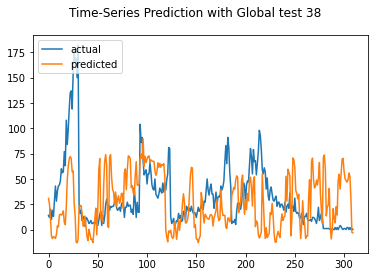

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 26.851
Test RMSE: 38.674
Test sMAPE: 122.891
Test R Squared: -0.508
{'mae': 26.85057443149628, 'rmse': 38.67406136813494, 'smape': 122.8911181036613, 'r2': -0.5075596276526113}


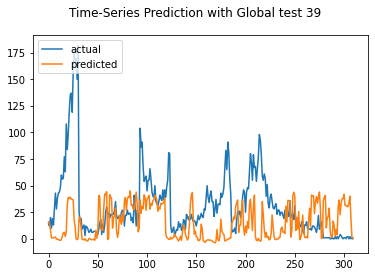

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 25.288
Test RMSE: 34.352
Test sMAPE: 77.925
Test R Squared: -0.189
{'mae': 25.28846516455374, 'rmse': 34.35243907543551, 'smape': 77.92476737718046, 'r2': -0.18946068128611215}


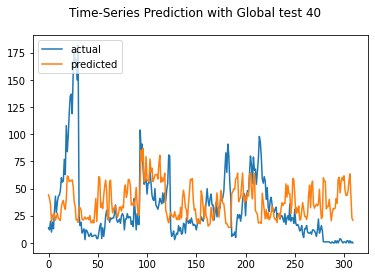

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 26.282
Test RMSE: 34.450
Test sMAPE: 83.413
Test R Squared: -0.196
{'mae': 26.28195151513623, 'rmse': 34.44970378860695, 'smape': 83.41338224045364, 'r2': -0.19620584056678192}


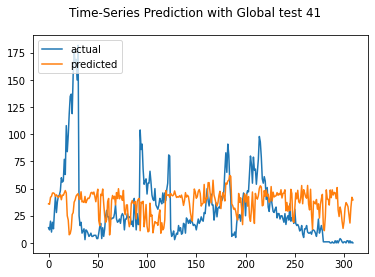

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 29.413
Test RMSE: 36.131
Test sMAPE: 83.406
Test R Squared: -0.316
{'mae': 29.413106204617414, 'rmse': 36.13101105662566, 'smape': 83.4056072471442, 'r2': -0.315816002254661}


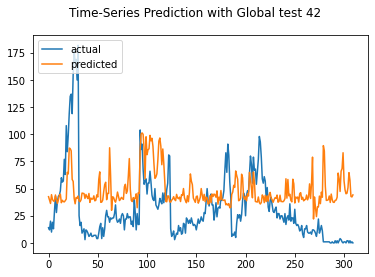

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 24.559
Test RMSE: 37.646
Test sMAPE: 104.896
Test R Squared: -0.429
{'mae': 24.55861801918476, 'rmse': 37.6464422519772, 'smape': 104.89648817896938, 'r2': -0.42850845137881555}


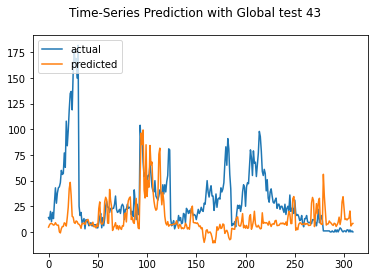

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 28.821
Test RMSE: 37.950
Test sMAPE: 98.222
Test R Squared: -0.452
{'mae': 28.820822197487278, 'rmse': 37.949818305163696, 'smape': 98.22229826052163, 'r2': -0.45162465677817343}


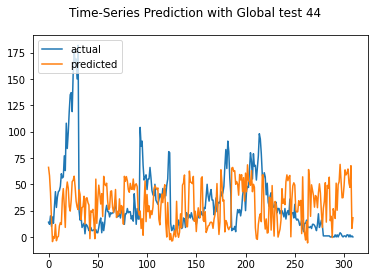

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 28.403
Test RMSE: 37.370
Test sMAPE: 93.048
Test R Squared: -0.408
{'mae': 28.403067248578996, 'rmse': 37.37022756617365, 'smape': 93.04771913522647, 'r2': -0.407623210874825}


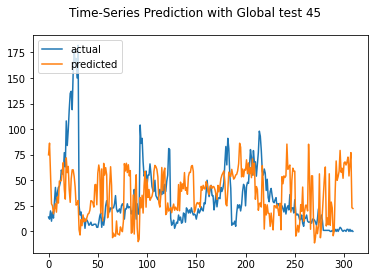

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 22.184
Test RMSE: 35.765
Test sMAPE: 83.176
Test R Squared: -0.289
{'mae': 22.184016996814357, 'rmse': 35.764726952374886, 'smape': 83.17623188771259, 'r2': -0.28927262666180664}


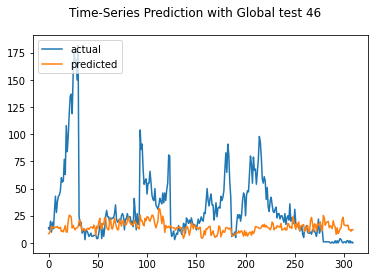

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 32.284
Test RMSE: 42.102
Test sMAPE: 86.881
Test R Squared: -0.787
{'mae': 32.283527159690856, 'rmse': 42.102364632353094, 'smape': 86.88072488969591, 'r2': -0.7866846689518014}


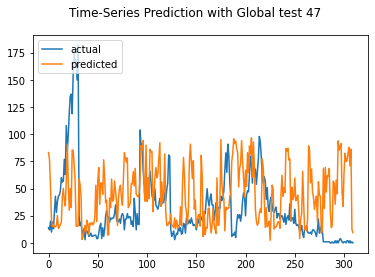

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 24.125
Test RMSE: 36.987
Test sMAPE: 103.170
Test R Squared: -0.379
{'mae': 24.124617355869663, 'rmse': 36.98677035531186, 'smape': 103.16988100503372, 'r2': -0.3788840759821377}


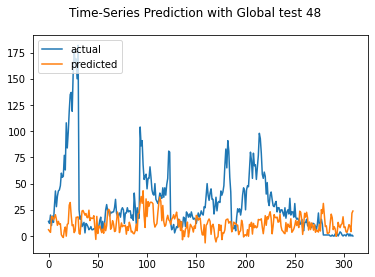

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 33.005
Test RMSE: 40.171
Test sMAPE: 87.203
Test R Squared: -0.627
{'mae': 33.004983662020784, 'rmse': 40.17106466696245, 'smape': 87.20289802105637, 'r2': -0.6265282804317114}


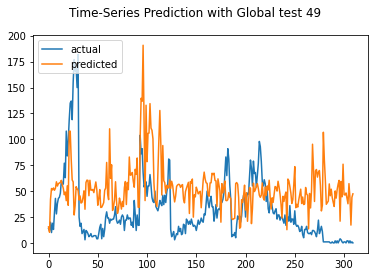

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 27.920
Test RMSE: 35.299
Test sMAPE: 81.174
Test R Squared: -0.256
{'mae': 27.919774000106326, 'rmse': 35.298821226092294, 'smape': 81.17447216975827, 'r2': -0.25590080833952045}


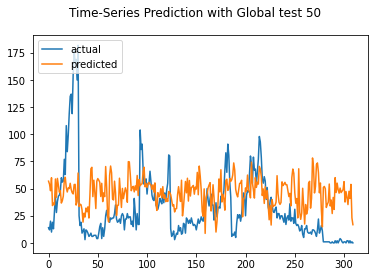

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 26.399
Test RMSE: 36.256
Test sMAPE: 86.301
Test R Squared: -0.325
{'mae': 26.398510958494683, 'rmse': 36.25568752457156, 'smape': 86.30125523111832, 'r2': -0.3249125833286337}


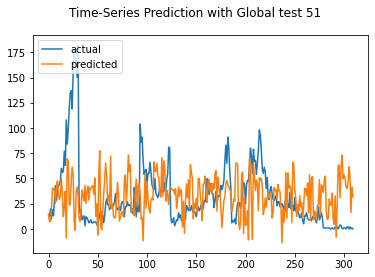

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 27.180
Test RMSE: 38.692
Test sMAPE: 83.649
Test R Squared: -0.509
{'mae': 27.180371563953738, 'rmse': 38.691701180151085, 'smape': 83.64880190532625, 'r2': -0.5089351818219987}


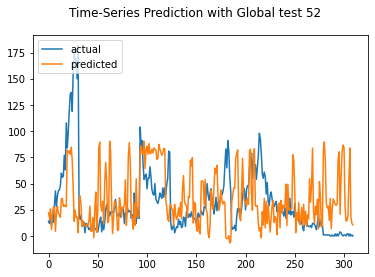

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 29.248
Test RMSE: 38.790
Test sMAPE: 103.265
Test R Squared: -0.517
{'mae': 29.247610316161186, 'rmse': 38.79035950948352, 'smape': 103.26490197278434, 'r2': -0.516640132339615}


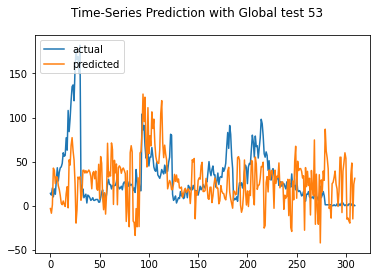

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 30.636
Test RMSE: 37.650
Test sMAPE: 84.804
Test R Squared: -0.429
{'mae': 30.636205950090968, 'rmse': 37.65017377422984, 'smape': 84.80443705769405, 'r2': -0.42879165345243186}


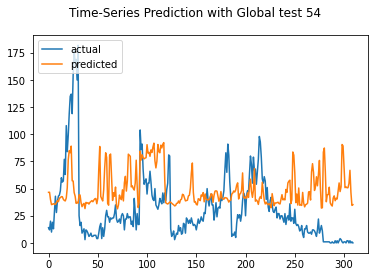

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 24.499
Test RMSE: 35.453
Test sMAPE: 103.114
Test R Squared: -0.267
{'mae': 24.499296491088405, 'rmse': 35.45279816823291, 'smape': 103.11364607749283, 'r2': -0.2668814320647026}


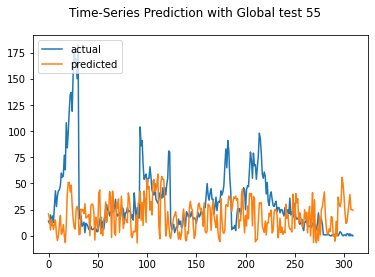

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 35.570
Test RMSE: 42.528
Test sMAPE: 90.198
Test R Squared: -0.823
{'mae': 35.56973976319836, 'rmse': 42.52821768432887, 'smape': 90.19788876794125, 'r2': -0.8230110410911811}


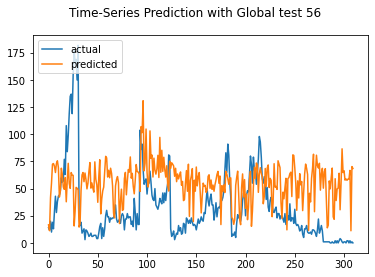

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 31.828
Test RMSE: 38.170
Test sMAPE: 87.224
Test R Squared: -0.469
{'mae': 31.827779646842718, 'rmse': 38.16994919659082, 'smape': 87.22439941008872, 'r2': -0.468514024051331}


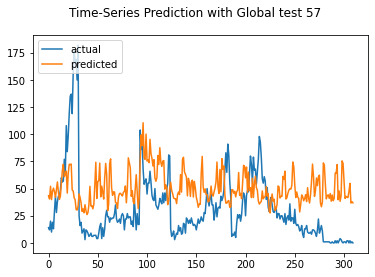

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 30.219
Test RMSE: 37.441
Test sMAPE: 84.958
Test R Squared: -0.413
{'mae': 30.21905096730879, 'rmse': 37.441013159961564, 'smape': 84.95763464124582, 'r2': -0.4129608188248006}


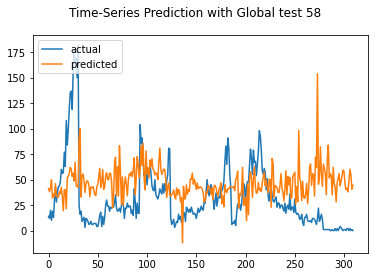

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 25.441
Test RMSE: 34.608
Test sMAPE: 83.922
Test R Squared: -0.207
{'mae': 25.44091208288747, 'rmse': 34.60776735400457, 'smape': 83.92200100243818, 'r2': -0.2072079859405369}


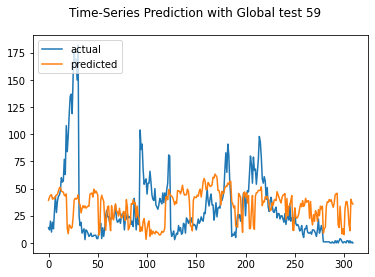

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 26.791
Test RMSE: 34.827
Test sMAPE: 80.996
Test R Squared: -0.223
{'mae': 26.790869793872684, 'rmse': 34.8265214184236, 'smape': 80.99592011984113, 'r2': -0.22251762869496017}


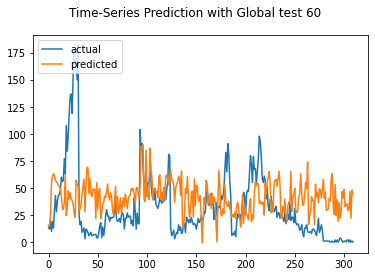

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 27.985
Test RMSE: 34.885
Test sMAPE: 83.882
Test R Squared: -0.227
{'mae': 27.985443161379905, 'rmse': 34.88459141137211, 'smape': 83.8823112446998, 'r2': -0.22659789701511257}


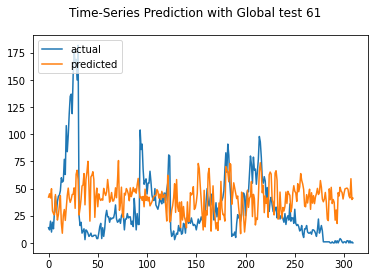

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 21.162
Test RMSE: 34.763
Test sMAPE: 79.732
Test R Squared: -0.218
{'mae': 21.162461661907933, 'rmse': 34.763377884565635, 'smape': 79.73221662630083, 'r2': -0.21808858437350387}


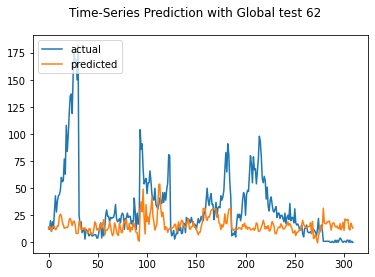

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 36.941
Test RMSE: 45.396
Test sMAPE: 93.842
Test R Squared: -1.077
{'mae': 36.9408643545643, 'rmse': 45.39564755077368, 'smape': 93.84154919133024, 'r2': -1.0771285040747345}


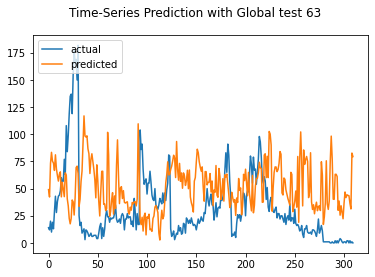

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 36.766
Test RMSE: 44.834
Test sMAPE: 90.654
Test R Squared: -1.026
{'mae': 36.76643578314012, 'rmse': 44.83420648272778, 'smape': 90.65364930604703, 'r2': -1.026067498151615}


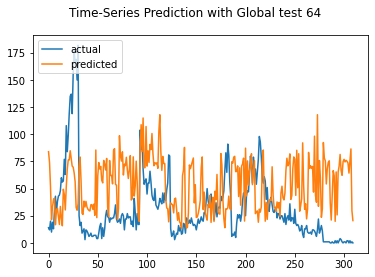

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 35.746
Test RMSE: 42.204
Test sMAPE: 94.713
Test R Squared: -0.795
{'mae': 35.74568838150271, 'rmse': 42.20371642028995, 'smape': 94.71291763735978, 'r2': -0.7952970899397613}


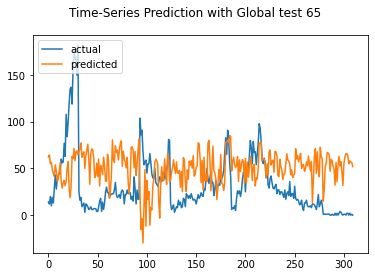

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 36.865
Test RMSE: 42.697
Test sMAPE: 93.050
Test R Squared: -0.837
{'mae': 36.86544246673584, 'rmse': 42.69676907669988, 'smape': 93.05013462230609, 'r2': -0.8374898961770456}


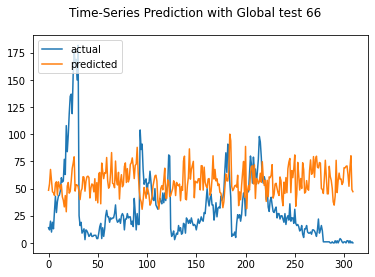

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 31.845
Test RMSE: 40.960
Test sMAPE: 90.172
Test R Squared: -0.691
{'mae': 31.845325961420613, 'rmse': 40.960313885719266, 'smape': 90.17208295966022, 'r2': -0.6910696163646983}


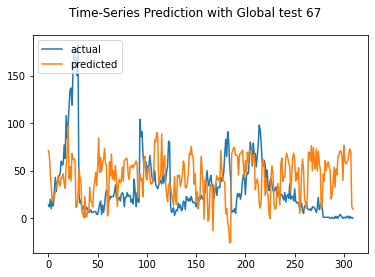

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 30.232
Test RMSE: 36.647
Test sMAPE: 84.818
Test R Squared: -0.354
{'mae': 30.232095416899657, 'rmse': 36.647387194509804, 'smape': 84.81809027720077, 'r2': -0.35369544598401004}


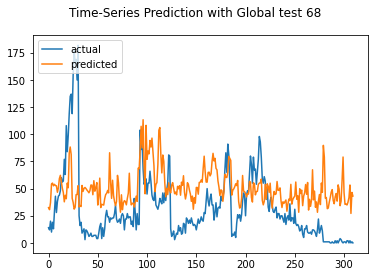

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 23.765
Test RMSE: 34.510
Test sMAPE: 96.642
Test R Squared: -0.200
{'mae': 23.765112878718682, 'rmse': 34.50959353919428, 'smape': 96.6419119959964, 'r2': -0.2003685899627763}


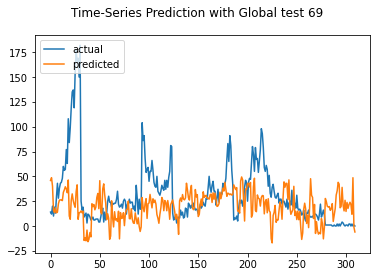

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 29.822
Test RMSE: 37.211
Test sMAPE: 84.468
Test R Squared: -0.396
{'mae': 29.82249172579858, 'rmse': 37.21051133809576, 'smape': 84.46762113761916, 'r2': -0.39561687021828673}


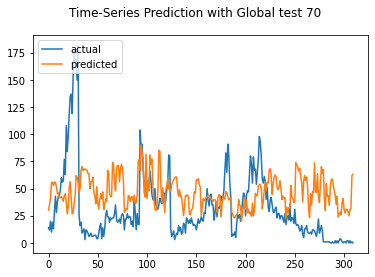

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 21.989
Test RMSE: 30.755
Test sMAPE: 72.627
Test R Squared: 0.047
{'mae': 21.98899126052857, 'rmse': 30.755282797762227, 'smape': 72.62744794437423, 'r2': 0.046601676288598126}


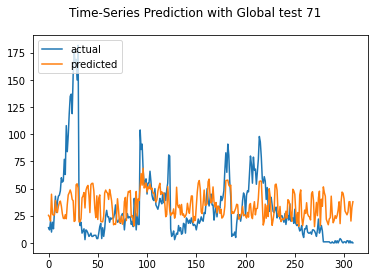

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 31.034
Test RMSE: 38.989
Test sMAPE: 86.211
Test R Squared: -0.532
{'mae': 31.034375746788516, 'rmse': 38.989279222965436, 'smape': 86.2111035795139, 'r2': -0.5322348918255151}


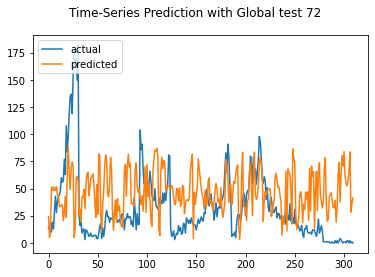

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 26.872
Test RMSE: 33.712
Test sMAPE: 82.068
Test R Squared: -0.145
{'mae': 26.871557801769633, 'rmse': 33.71151438459288, 'smape': 82.06813526631048, 'r2': -0.1454904137252213}


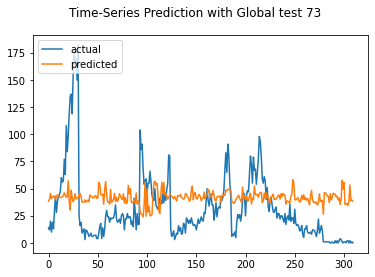

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 28.770
Test RMSE: 35.250
Test sMAPE: 83.803
Test R Squared: -0.252
{'mae': 28.76990007585095, 'rmse': 35.250499375990074, 'smape': 83.80274189984654, 'r2': -0.2524646645896931}


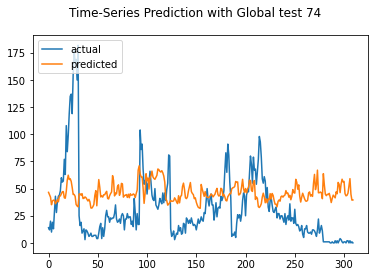

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 26.566
Test RMSE: 34.565
Test sMAPE: 82.319
Test R Squared: -0.204
{'mae': 26.566139085831182, 'rmse': 34.56490632557461, 'smape': 82.31871376701166, 'r2': -0.2042196316527931}


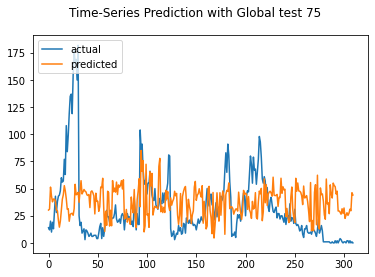

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 32.771
Test RMSE: 40.874
Test sMAPE: 92.939
Test R Squared: -0.684
{'mae': 32.771443641378035, 'rmse': 40.87431321656255, 'smape': 92.93918486508315, 'r2': -0.6839758991331499}


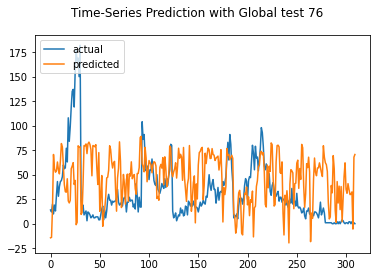

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 31.909
Test RMSE: 39.678
Test sMAPE: 90.042
Test R Squared: -0.587
{'mae': 31.90889735260318, 'rmse': 39.677673735695116, 'smape': 90.04222962976971, 'r2': -0.5868188044566995}


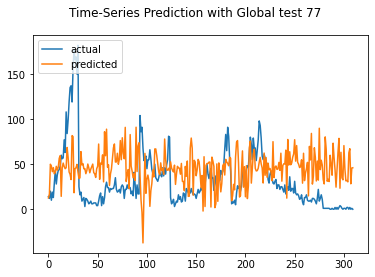

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 22.572
Test RMSE: 32.155
Test sMAPE: 76.675
Test R Squared: -0.042
{'mae': 22.57235909123575, 'rmse': 32.15536999070167, 'smape': 76.67504895804795, 'r2': -0.04217813327598807}


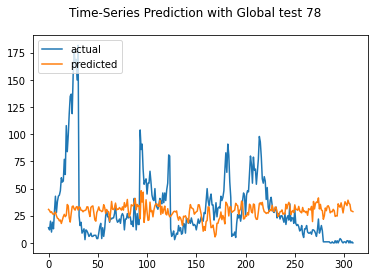

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 27.658
Test RMSE: 36.905
Test sMAPE: 81.477
Test R Squared: -0.373
{'mae': 27.658205415356544, 'rmse': 36.90503678335098, 'smape': 81.47703353008153, 'r2': -0.37279667792142623}


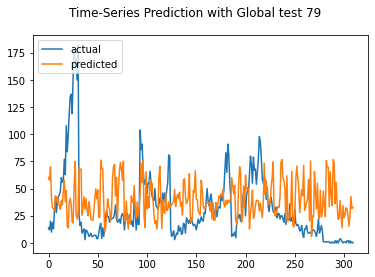

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 27.498
Test RMSE: 36.152
Test sMAPE: 83.482
Test R Squared: -0.317
{'mae': 27.498100920646422, 'rmse': 36.15156461563248, 'smape': 83.48200416995039, 'r2': -0.3173134634883681}


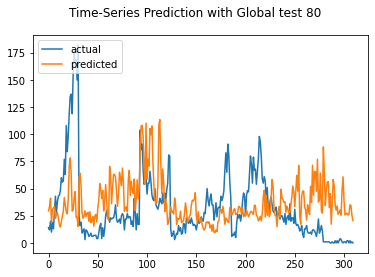

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 32.550
Test RMSE: 37.761
Test sMAPE: 89.337
Test R Squared: -0.437
{'mae': 32.55029110447054, 'rmse': 37.761380273347186, 'smape': 89.3365420966802, 'r2': -0.43724450017904193}


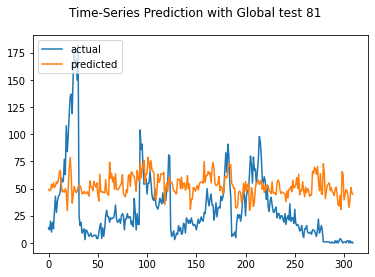

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 34.744
Test RMSE: 44.677
Test sMAPE: 109.856
Test R Squared: -1.012
{'mae': 34.74367068361852, 'rmse': 44.67692145278747, 'smape': 109.85562276167208, 'r2': -1.0118769440565996}


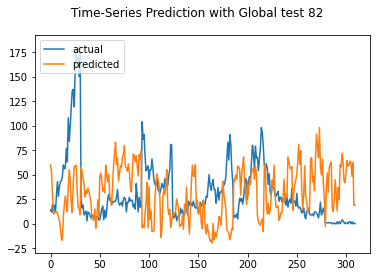

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 26.922
Test RMSE: 35.918
Test sMAPE: 80.386
Test R Squared: -0.300
{'mae': 26.921634366435395, 'rmse': 35.91800628743482, 'smape': 80.38640084767908, 'r2': -0.3003473554300933}


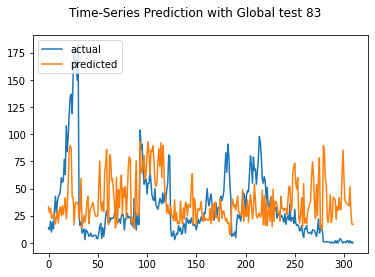

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 32.771
Test RMSE: 38.824
Test sMAPE: 89.441
Test R Squared: -0.519
{'mae': 32.77119507328157, 'rmse': 38.82373049025737, 'smape': 89.44104211296666, 'r2': -0.5192507572346292}


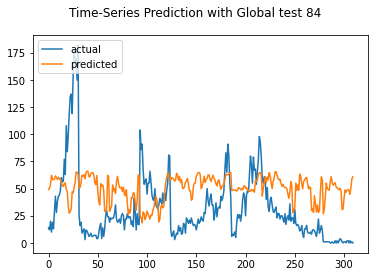

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 27.127
Test RMSE: 34.527
Test sMAPE: 80.113
Test R Squared: -0.202
{'mae': 27.1273805433704, 'rmse': 34.5266005806708, 'smape': 80.11347262169588, 'r2': -0.20155201443696824}


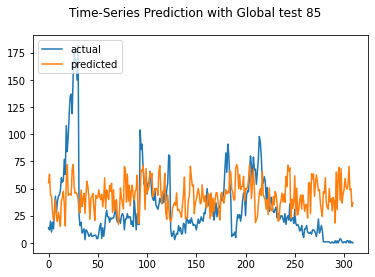

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 24.273
Test RMSE: 36.248
Test sMAPE: 87.296
Test R Squared: -0.324
{'mae': 24.273048963758253, 'rmse': 36.247920238653386, 'smape': 87.29625702853625, 'r2': -0.32434495528440377}


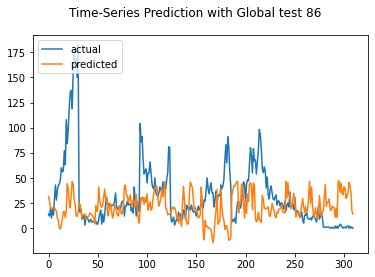

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 30.987
Test RMSE: 40.838
Test sMAPE: 98.235
Test R Squared: -0.681
{'mae': 30.98748522650811, 'rmse': 40.83814959776468, 'smape': 98.23498148913384, 'r2': -0.6809974161890848}


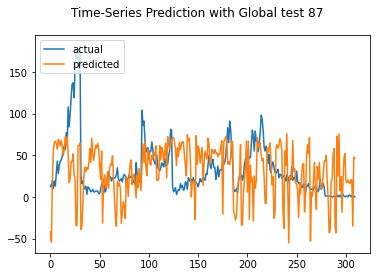

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 31.715
Test RMSE: 38.046
Test sMAPE: 88.021
Test R Squared: -0.459
{'mae': 31.715041400540258, 'rmse': 38.04628805835071, 'smape': 88.02054698501144, 'r2': -0.45901419744970773}


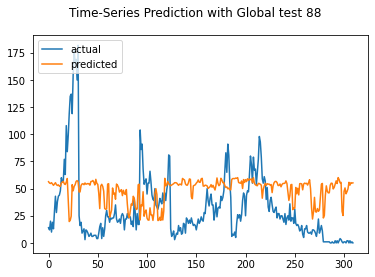

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 25.284
Test RMSE: 34.640
Test sMAPE: 85.502
Test R Squared: -0.209
{'mae': 25.28366711370407, 'rmse': 34.63981492333245, 'smape': 85.50242297423176, 'r2': -0.2094448245231959}


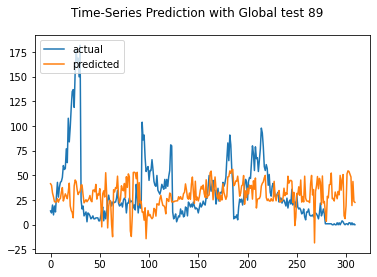

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 33.207
Test RMSE: 41.306
Test sMAPE: 88.405
Test R Squared: -0.720
{'mae': 33.20689639583711, 'rmse': 41.30558488912157, 'smape': 88.40451065886135, 'r2': -0.7196991905189931}


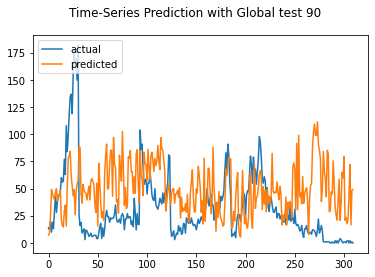

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 22.967
Test RMSE: 36.264
Test sMAPE: 86.263
Test R Squared: -0.326
{'mae': 22.96675675376769, 'rmse': 36.26416330950821, 'smape': 86.26271373653069, 'r2': -0.32553212677181653}


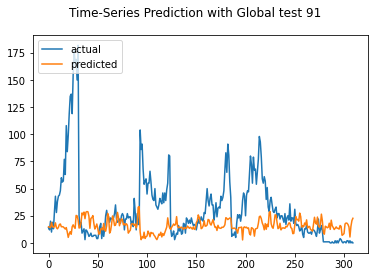

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 34.601
Test RMSE: 41.485
Test sMAPE: 88.711
Test R Squared: -0.735
{'mae': 34.60117467449558, 'rmse': 41.485136988927245, 'smape': 88.71097790944216, 'r2': -0.7346824773088785}


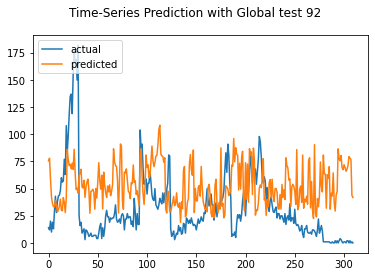

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 22.767
Test RMSE: 35.564
Test sMAPE: 87.188
Test R Squared: -0.275
{'mae': 22.76671610955269, 'rmse': 35.563900115072364, 'smape': 87.18838253648836, 'r2': -0.2748341774954064}


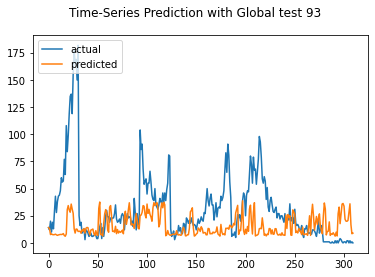

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 33.697
Test RMSE: 40.968
Test sMAPE: 89.164
Test R Squared: -0.692
{'mae': 33.69656412601471, 'rmse': 40.967753369537924, 'smape': 89.16363124508253, 'r2': -0.6916839587047492}


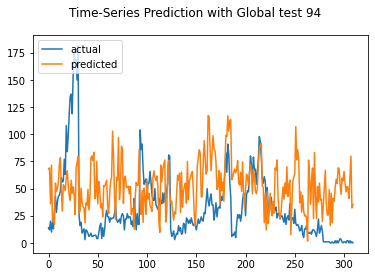

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 26.214
Test RMSE: 33.279
Test sMAPE: 79.348
Test R Squared: -0.116
{'mae': 26.21354916384144, 'rmse': 33.279108546758465, 'smape': 79.34838029058822, 'r2': -0.11629326114932192}


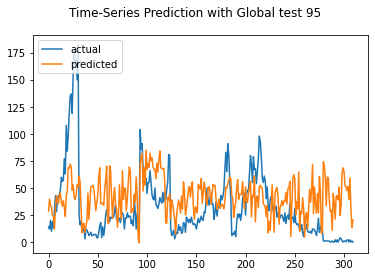

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 28.015
Test RMSE: 35.041
Test sMAPE: 84.894
Test R Squared: -0.238
{'mae': 28.01503825802957, 'rmse': 35.04079276477428, 'smape': 84.8944143355583, 'r2': -0.23760706727045533}


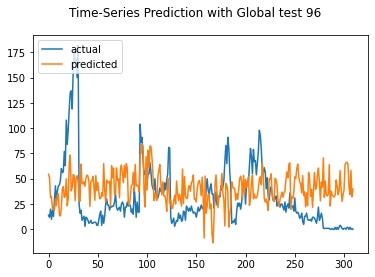

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 27.347
Test RMSE: 37.092
Test sMAPE: 81.133
Test R Squared: -0.387
{'mae': 27.346753061202264, 'rmse': 37.091579083748826, 'smape': 81.13283358899646, 'r2': -0.3867097847860981}


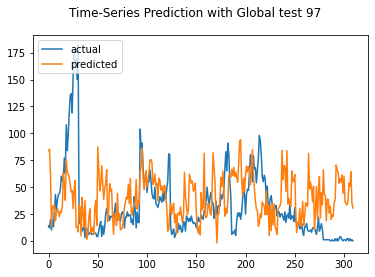

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 30.364
Test RMSE: 39.132
Test sMAPE: 86.940
Test R Squared: -0.544
{'mae': 30.364146651760226, 'rmse': 39.1324618315387, 'smape': 86.94020974420572, 'r2': -0.5435093873471284}


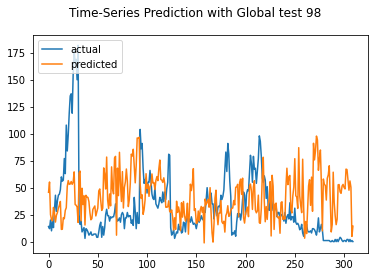

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 31.000
Test RMSE: 38.269
Test sMAPE: 90.292
Test R Squared: -0.476
{'mae': 31.000167915513444, 'rmse': 38.26870481410307, 'smape': 90.29185224921059, 'r2': -0.4761227120271949}


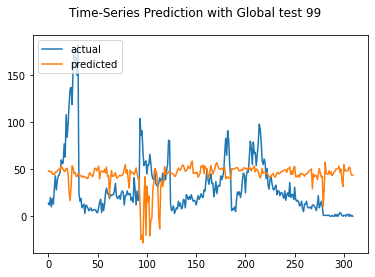

rmse : average=38.331, std=3.584
mae : average=29.411, std=4.544
smape : average=90.333, std=10.268
r2 : average=-0.494, std=0.284


([38.33121084316737, 3.5835382886709555],
 [29.4110838320313, 4.543906700452299],
 [90.33259839590256, 10.26796275248091],
 [-0.4938924054847272, 0.28370815905688107])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')